In [1]:
import dask.array as da
import napari
from skimage.io import imread, imshow, imsave

# Very quick to load whole single-channel mosaic stack from Zarr file format

In [2]:
da_stack_gfp = da.from_zarr(f"data/zt_stack_ch{1}.zarr")
da_stack_rfp = da.from_zarr(f"data/zt_stack_ch{2}.zarr")

In [3]:
da_stack_gfp

,Array,Chunk
Bytes,15.33 GiB,8.90 MiB
Shape,"(3, 75, 6048, 6048)","(1, 1, 2160, 2160)"
Count,2026 Tasks,2025 Chunks
Type,uint16,numpy.ndarray


### 9.2GB on disk for a 15.33GB 4D stack

Uncompressed version is 10.5GB for a single-channel

In [19]:
da_stack_gfp.astype('u1')

,Array,Chunk
Bytes,7.66 GiB,4.45 MiB
Shape,"(3, 75, 6048, 6048)","(1, 1, 2160, 2160)"
Count,4051 Tasks,2025 Chunks
Type,uint8,numpy.ndarray


In [22]:
v = napari.Viewer()
v.add_image(da_stack_gfp.astype('u1'), name="gfp", contrast_limits = [0,255], blending = 'additive', colormap= 'green')# colormap = 'g')

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:179: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


<Image layer 'gfp' at 0x7f4f780a1040>

### Doesn't look right as uint8

In [23]:
da_stack_gfp_8bit = da_stack_gfp.astype('u1')

In [28]:
da_stack_gfp_8bit[0][0]

dask.array<getitem, shape=(6048, 6048), dtype=uint8, chunksize=(2160, 2160), chunktype=numpy.ndarray>

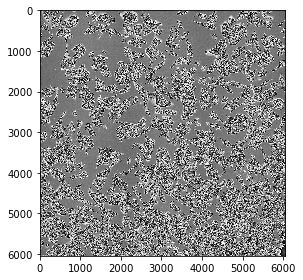

In [29]:
imshow(da_stack_gfp_8bit[0][0])

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


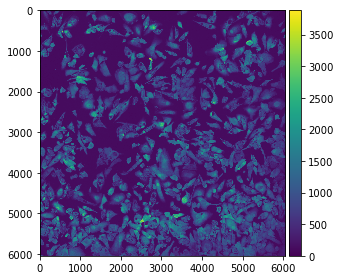

In [30]:
imshow(da_stack_gfp[0][0])

### Loading zarr arrays explictly saved out as 8bit

In [31]:
da_stack_gfp_8bit = da.from_zarr(f"zt_stack_ch{1}.zarr")

In [46]:
da_stack_gfp_8bit[0][0]#.astype('u1')

dask.array<getitem, shape=(6048, 6048), dtype=uint16, chunksize=(2160, 2160), chunktype=numpy.ndarray>

Loaded from 8-bit implementation of zarr but still is loaded as 16-bit... 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


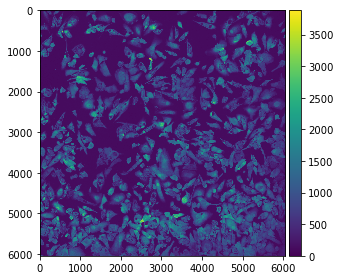

In [39]:
imshow(da_stack_gfp_8bit[0][0])

In [47]:
da_stack_gfp

,Array,Chunk
Bytes,15.33 GiB,8.90 MiB
Shape,"(3, 75, 6048, 6048)","(1, 1, 2160, 2160)"
Count,2026 Tasks,2025 Chunks
Type,uint16,numpy.ndarray


In [45]:
da_stack_rfp

,Array,Chunk
Bytes,15.33 GiB,8.90 MiB
Shape,"(3, 75, 6048, 6048)","(1, 1, 2160, 2160)"
Count,2026 Tasks,2025 Chunks
Type,uint16,numpy.ndarray


In [48]:
%time da_stack_gfp.compute()

CPU times: user 20.6 s, sys: 1min, total: 1min 21s
Wall time: 45.4 s


array([[[[ 114,  120,  108, ...,  106,  108,    0],
         [ 112,  122,  110, ...,  106,  104,    0],
         [ 115,  121,  118, ...,  105,  107,    0],
         ...,
         [1036,  982,  924, ...,  265,  264,    0],
         [1082, 1005,  969, ...,  254,  249,    0],
         [   0,    0,    0, ...,    0,    0,    0]],

        [[ 110,  111,  111, ...,  112,  107,    0],
         [ 111,  109,  104, ...,  108,  108,    0],
         [ 107,  110,  107, ...,  106,  105,    0],
         ...,
         [1031, 1059, 1102, ...,  431,  410,    0],
         [1047, 1082, 1096, ...,  437,  422,    0],
         [   0,    0,    0, ...,    0,    0,    0]],

        [[ 101,  105,  104, ...,  105,  103,    0],
         [  99,  103,  101, ...,   97,   97,    0],
         [ 108,  107,  106, ...,  104,  100,    0],
         ...,
         [1002,  989, 1000, ...,  308,  315,    0],
         [1010,  995, 1000, ...,  332,  316,    0],
         [   0,    0,    0, ...,    0,    0,    0]],

        ...,

  

In [54]:
import sys
sys.path.append('../')
import tb_sandbox.data_utils as du

In [56]:
du.size(da_stack_gfp.compute(dtype = 'u1'))

'15.33 GB'

#### Data summary

There is not much in the way of data savings by compressing as zarr.

It does allow for a rapid loading of the entire stacked mosaic as a dask array.

Need the images to be mosaic in order to run later segmentation etc. 

Further image processing can be implemented on the dask array, removing the need to load each stacked mosaic into the memory each time (takes 1.5 mins to load 1 channel).

Is there a way I can just save the transformations of the mosaic without saving out as zarr? Or would the compilation time for each mosaic render this pointless? Currently takes a couple of minutes per channel to compile as mosaic. 

What are the advantages of doing it this way over saving it out as a .tiff? 
Zarr is compressed so I'm saving a couple of GB of disk space per acquisition.
It is also saved as a per-frame, per-tile chunked array so I don't have to wait minutes to load the data structure into the memory.
But this could be done if I saved the tiled array out as a list of tiff files... let's try this to compare.

| Type                      | Zarr size     | Dask Array size | Numpy array size | .tiff size     |
|---------------------------|---------------|-----------------|------------------|----------------|
| Background removed 16-bit | 17.5GB (2 ch) | ""              | ""               | n/a            |
| Background remains 16-bit | 17.GB (2 ch)  | 30.66GB  (2 ch) | ""               | 21.0GB  (2 ch) |
| 8-bit                     | 16.5GB (2 ch) | ""              | ""               | n/a            |
| Single frame tiff         | n/a           | ""              | ""               | 33.0GB (2 ch)  |
| Tiled at 1080px sq        | 17.4GB (2 ch) | ""              | ""               | n/a            |
| Saved as .hdf5/.tbd       |                          38.0GB (2 ch)                              |

## Saving out zarr array as list of tiled mosaic tiff files

For data comparison purposes.

In [58]:
da_stack_gfp.shape

(3, 75, 6048, 6048)

In [62]:
for plane in da_stack_gfp:
    for frame in plane:
        print(frame)
        test = frame
        break

dask.array<getitem, shape=(6048, 6048), dtype=uint16, chunksize=(2160, 2160), chunktype=numpy.ndarray>
dask.array<getitem, shape=(6048, 6048), dtype=uint16, chunksize=(2160, 2160), chunktype=numpy.ndarray>
dask.array<getitem, shape=(6048, 6048), dtype=uint16, chunksize=(2160, 2160), chunktype=numpy.ndarray>


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


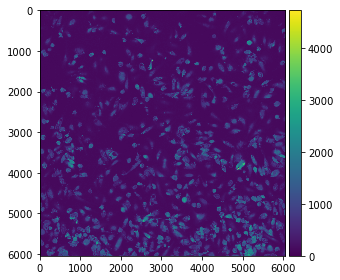

In [64]:
imshow(frame)

In [66]:
du.size(frame.compute())

'69.77 MB'

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


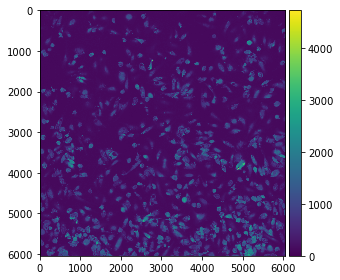

In [68]:
imshow(frame.compute(dtype = 'uint8'))

In [70]:
du.size(frame.compute(dtype = 'u1'))

'69.77 MB'

In [71]:
!mkdir '/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/tiled_frames_tiff'

In [72]:
output_path = '/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/tiled_frames_tiff/'

In [76]:
for p, plane in enumerate(da_stack_gfp):
    print(p, plane)
    break

0 dask.array<getitem, shape=(75, 6048, 6048), dtype=uint16, chunksize=(1, 2160, 2160), chunktype=numpy.ndarray>


In [82]:
for p, plane in enumerate(da_stack_gfp):
    for t, frame in tqdm(enumerate(plane), total = len(plane)):
        imsave(os.path.join(output_path, f'r03c03f00p0{p+1}-ch1sk{t+1}fk1fl1.tiff'), frame)

  0%|          | 0/75 [00:00<?, ?it/s]

/tmp/ipykernel_748915/900750713.py:3: UserWarning: /mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/tiled_frames_tiff/r03c03f00p01-ch1sk1fk1fl1.tiff is a low contrast image
  imsave(os.path.join(output_path, f'r03c03f00p0{p+1}-ch1sk{t+1}fk1fl1.tiff'), frame)
/tmp/ipykernel_748915/900750713.py:3: UserWarning: /mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/tiled_frames_tiff/r03c03f00p01-ch1sk2fk1fl1.tiff is a low contrast image
  imsave(os.path.join(output_path, f'r03c03f00p0{p+1}-ch1sk{t+1}fk1fl1.tiff'), frame)
/tmp/ipykernel_748915/900750713.py:3: UserWarning: /mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/tiled_frames_tiff/r03c03f00p01-ch1sk3fk1fl1.tiff is a low contrast image
  imsave(os.path.join(output_path, f'r03c03f00p0{p+1}-ch1sk{t+1}fk1fl1.tiff'), frame)
/tmp/ipykernel_748915/900750713.py:3: UserWarning: /mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/tiled_frames_tiff/r03c03f00p01-ch1sk4fk

/tmp/ipykernel_748915/900750713.py:3: UserWarning: /mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/tiled_frames_tiff/r03c03f00p01-ch1sk31fk1fl1.tiff is a low contrast image
  imsave(os.path.join(output_path, f'r03c03f00p0{p+1}-ch1sk{t+1}fk1fl1.tiff'), frame)
/tmp/ipykernel_748915/900750713.py:3: UserWarning: /mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/tiled_frames_tiff/r03c03f00p01-ch1sk32fk1fl1.tiff is a low contrast image
  imsave(os.path.join(output_path, f'r03c03f00p0{p+1}-ch1sk{t+1}fk1fl1.tiff'), frame)
/tmp/ipykernel_748915/900750713.py:3: UserWarning: /mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/tiled_frames_tiff/r03c03f00p01-ch1sk33fk1fl1.tiff is a low contrast image
  imsave(os.path.join(output_path, f'r03c03f00p0{p+1}-ch1sk{t+1}fk1fl1.tiff'), frame)
/tmp/ipykernel_748915/900750713.py:3: UserWarning: /mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/tiled_frames_tiff/r03c03f00p01-ch1sk

/tmp/ipykernel_748915/900750713.py:3: UserWarning: /mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/tiled_frames_tiff/r03c03f00p01-ch1sk61fk1fl1.tiff is a low contrast image
  imsave(os.path.join(output_path, f'r03c03f00p0{p+1}-ch1sk{t+1}fk1fl1.tiff'), frame)
/tmp/ipykernel_748915/900750713.py:3: UserWarning: /mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/tiled_frames_tiff/r03c03f00p01-ch1sk62fk1fl1.tiff is a low contrast image
  imsave(os.path.join(output_path, f'r03c03f00p0{p+1}-ch1sk{t+1}fk1fl1.tiff'), frame)
/tmp/ipykernel_748915/900750713.py:3: UserWarning: /mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/tiled_frames_tiff/r03c03f00p01-ch1sk63fk1fl1.tiff is a low contrast image
  imsave(os.path.join(output_path, f'r03c03f00p0{p+1}-ch1sk{t+1}fk1fl1.tiff'), frame)
/tmp/ipykernel_748915/900750713.py:3: UserWarning: /mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/tiled_frames_tiff/r03c03f00p01-ch1sk

  0%|          | 0/75 [00:00<?, ?it/s]

/tmp/ipykernel_748915/900750713.py:3: UserWarning: /mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/tiled_frames_tiff/r03c03f00p02-ch1sk1fk1fl1.tiff is a low contrast image
  imsave(os.path.join(output_path, f'r03c03f00p0{p+1}-ch1sk{t+1}fk1fl1.tiff'), frame)
/tmp/ipykernel_748915/900750713.py:3: UserWarning: /mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/tiled_frames_tiff/r03c03f00p02-ch1sk2fk1fl1.tiff is a low contrast image
  imsave(os.path.join(output_path, f'r03c03f00p0{p+1}-ch1sk{t+1}fk1fl1.tiff'), frame)
/tmp/ipykernel_748915/900750713.py:3: UserWarning: /mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/tiled_frames_tiff/r03c03f00p02-ch1sk3fk1fl1.tiff is a low contrast image
  imsave(os.path.join(output_path, f'r03c03f00p0{p+1}-ch1sk{t+1}fk1fl1.tiff'), frame)
/tmp/ipykernel_748915/900750713.py:3: UserWarning: /mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/tiled_frames_tiff/r03c03f00p02-ch1sk4fk

/tmp/ipykernel_748915/900750713.py:3: UserWarning: /mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/tiled_frames_tiff/r03c03f00p02-ch1sk31fk1fl1.tiff is a low contrast image
  imsave(os.path.join(output_path, f'r03c03f00p0{p+1}-ch1sk{t+1}fk1fl1.tiff'), frame)
/tmp/ipykernel_748915/900750713.py:3: UserWarning: /mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/tiled_frames_tiff/r03c03f00p02-ch1sk32fk1fl1.tiff is a low contrast image
  imsave(os.path.join(output_path, f'r03c03f00p0{p+1}-ch1sk{t+1}fk1fl1.tiff'), frame)
/tmp/ipykernel_748915/900750713.py:3: UserWarning: /mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/tiled_frames_tiff/r03c03f00p02-ch1sk33fk1fl1.tiff is a low contrast image
  imsave(os.path.join(output_path, f'r03c03f00p0{p+1}-ch1sk{t+1}fk1fl1.tiff'), frame)
/tmp/ipykernel_748915/900750713.py:3: UserWarning: /mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/tiled_frames_tiff/r03c03f00p02-ch1sk

/tmp/ipykernel_748915/900750713.py:3: UserWarning: /mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/tiled_frames_tiff/r03c03f00p02-ch1sk61fk1fl1.tiff is a low contrast image
  imsave(os.path.join(output_path, f'r03c03f00p0{p+1}-ch1sk{t+1}fk1fl1.tiff'), frame)
/tmp/ipykernel_748915/900750713.py:3: UserWarning: /mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/tiled_frames_tiff/r03c03f00p02-ch1sk62fk1fl1.tiff is a low contrast image
  imsave(os.path.join(output_path, f'r03c03f00p0{p+1}-ch1sk{t+1}fk1fl1.tiff'), frame)
/tmp/ipykernel_748915/900750713.py:3: UserWarning: /mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/tiled_frames_tiff/r03c03f00p02-ch1sk63fk1fl1.tiff is a low contrast image
  imsave(os.path.join(output_path, f'r03c03f00p0{p+1}-ch1sk{t+1}fk1fl1.tiff'), frame)
/tmp/ipykernel_748915/900750713.py:3: UserWarning: /mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/tiled_frames_tiff/r03c03f00p02-ch1sk

  0%|          | 0/75 [00:00<?, ?it/s]

/tmp/ipykernel_748915/900750713.py:3: UserWarning: /mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/tiled_frames_tiff/r03c03f00p03-ch1sk1fk1fl1.tiff is a low contrast image
  imsave(os.path.join(output_path, f'r03c03f00p0{p+1}-ch1sk{t+1}fk1fl1.tiff'), frame)
/tmp/ipykernel_748915/900750713.py:3: UserWarning: /mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/tiled_frames_tiff/r03c03f00p03-ch1sk2fk1fl1.tiff is a low contrast image
  imsave(os.path.join(output_path, f'r03c03f00p0{p+1}-ch1sk{t+1}fk1fl1.tiff'), frame)
/tmp/ipykernel_748915/900750713.py:3: UserWarning: /mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/tiled_frames_tiff/r03c03f00p03-ch1sk3fk1fl1.tiff is a low contrast image
  imsave(os.path.join(output_path, f'r03c03f00p0{p+1}-ch1sk{t+1}fk1fl1.tiff'), frame)
/tmp/ipykernel_748915/900750713.py:3: UserWarning: /mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/tiled_frames_tiff/r03c03f00p03-ch1sk4fk

/tmp/ipykernel_748915/900750713.py:3: UserWarning: /mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/tiled_frames_tiff/r03c03f00p03-ch1sk31fk1fl1.tiff is a low contrast image
  imsave(os.path.join(output_path, f'r03c03f00p0{p+1}-ch1sk{t+1}fk1fl1.tiff'), frame)
/tmp/ipykernel_748915/900750713.py:3: UserWarning: /mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/tiled_frames_tiff/r03c03f00p03-ch1sk32fk1fl1.tiff is a low contrast image
  imsave(os.path.join(output_path, f'r03c03f00p0{p+1}-ch1sk{t+1}fk1fl1.tiff'), frame)
/tmp/ipykernel_748915/900750713.py:3: UserWarning: /mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/tiled_frames_tiff/r03c03f00p03-ch1sk33fk1fl1.tiff is a low contrast image
  imsave(os.path.join(output_path, f'r03c03f00p0{p+1}-ch1sk{t+1}fk1fl1.tiff'), frame)
/tmp/ipykernel_748915/900750713.py:3: UserWarning: /mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/tiled_frames_tiff/r03c03f00p03-ch1sk

/tmp/ipykernel_748915/900750713.py:3: UserWarning: /mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/tiled_frames_tiff/r03c03f00p03-ch1sk61fk1fl1.tiff is a low contrast image
  imsave(os.path.join(output_path, f'r03c03f00p0{p+1}-ch1sk{t+1}fk1fl1.tiff'), frame)
/tmp/ipykernel_748915/900750713.py:3: UserWarning: /mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/tiled_frames_tiff/r03c03f00p03-ch1sk62fk1fl1.tiff is a low contrast image
  imsave(os.path.join(output_path, f'r03c03f00p0{p+1}-ch1sk{t+1}fk1fl1.tiff'), frame)
/tmp/ipykernel_748915/900750713.py:3: UserWarning: /mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/tiled_frames_tiff/r03c03f00p03-ch1sk63fk1fl1.tiff is a low contrast image
  imsave(os.path.join(output_path, f'r03c03f00p0{p+1}-ch1sk{t+1}fk1fl1.tiff'), frame)
/tmp/ipykernel_748915/900750713.py:3: UserWarning: /mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/tiled_frames_tiff/r03c03f00p03-ch1sk

In [90]:
from tqdm.auto import tqdm
import os, glob
import numpy as np

### Seems just as big on disk but obviously takes more time to load as shown below

In [91]:
stack = []
for fn in tqdm(os.listdir(output_path)):
    stack.append(imread(os.path.join(output_path, fn)))
%time stack = np.stack(stack, axis = 0)

  0%|          | 0/225 [00:00<?, ?it/s]

CPU times: user 4.07 s, sys: 54.6 s, total: 58.7 s
Wall time: 1min 1s


Takes 1 minute 44 seconds to load 1-channel 4D stack, so want to proceed using dask in some format.
The two options seem to be either an on-the-fly compilation of tiles into a mosaic, but that might be unsually computationally expensive for each individual time point.
So should proceed with either using the zarr as is, or finding an efficient way to save out as individual frame mosaics and load using dask octopus loader... 

### Before that, testing a different tile size (1080 compared to the previous regime of 2160)

Currently taking 10 minutes to compile a 1080 size tile.

In [99]:
da_stack_gfp = da.from_zarr(f"zt_stack_ch{1}_1080tile.zarr")

In [103]:
da_stack_gfp

,Array,Chunk
Bytes,15.33 GiB,2.22 MiB
Shape,"(3, 75, 6048, 6048)","(1, 1, 1080, 1080)"
Count,8101 Tasks,8100 Chunks
Type,uint16,numpy.ndarray


In [100]:
da_stack_gfp[0][0]

dask.array<getitem, shape=(6048, 6048), dtype=uint16, chunksize=(1080, 1080), chunktype=numpy.ndarray>

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


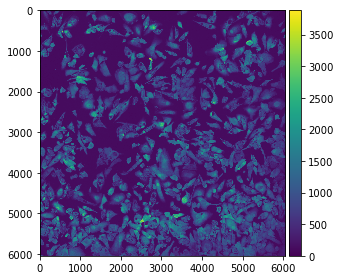

In [101]:
imshow(da_stack_gfp[0][0].compute())

In [102]:
v = napari.Viewer()
v.add_image(da_stack_gfp, name="gfp", blending = 'additive', colormap= 'green')# colormap = 'g')

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:179: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


<Image layer 'gfp' at 0x7f4edea2d550>

### Now testing whether it's worth to save out as zarr or to save out as single frame tiffs and write something in to octopus to load them as so...

In [108]:
!ls

DaskFusion_Example_sandbox_220720.ipynb		  README.md
DaskFusion_Example_sandbox_220721.2.ipynb	  requirements.txt
DaskFusion_Example_sandbox_220721.ipynb		  Untitled.ipynb
DaskFusion_Example_sandbox_max_proj_220722.ipynb  utils
data						  zt_stack_ch1_1080tile.zarr
data_comparisons_220725.ipynb			  zt_stack_ch2_1080tile.zarr
fuse


In [111]:
da_stack_gfp = da.from_zarr(f"data/zt_stack_ch1.zarr/")


In [112]:
da_stack_gfp

,Array,Chunk
Bytes,15.33 GiB,8.90 MiB
Shape,"(3, 75, 6048, 6048)","(1, 1, 2160, 2160)"
Count,2026 Tasks,2025 Chunks
Type,uint16,numpy.ndarray


### Can I compress this as a hdf5 or zarr even more than 9.2GB (1-ch)

In [ ]:
da_stack_gfp.to_zarr('data/test.zarr', storage_options)

In [118]:
%time da_stack_gfp.to_hdf5('data/test.hdf5', '/x')

CPU times: user 18.8 s, sys: 29.9 s, total: 48.7 s
Wall time: 30.5 s


In [119]:
%time da_stack_gfp.to_hdf5('data/test.hdf5','/x', compression='lzf')

CPU times: user 13.5 s, sys: 30.2 s, total: 43.6 s
Wall time: 1min


In [13]:
%time da_stack_gfp.to_tiledb('data/test.tdb')

CPU times: user 2min 5s, sys: 1min 44s, total: 3min 50s
Wall time: 21.1 s


### Testing final next gen file format option (NGFF)

In [5]:
da_stack_gfp.image

,Array,Chunk
Bytes,15.33 GiB,8.90 MiB
Shape,"(3, 75, 6048, 6048)","(1, 1, 2160, 2160)"
Count,2026 Tasks,2025 Chunks
Type,uint16,numpy.ndarray


In [25]:
import ngff_writer

In [4]:
import dask.array as da
import numpy as np
from dask_image.imread import imread

from ngff_writer.array_utils import affine_matrix_to_tczyx, to_tczyx
from ngff_writer.writer import open_ngff_zarr

with open_ngff_zarr(
    store="output.zarr",
    dimension_separator="/",
    overwrite=True,
) as f:
    channel_paths = ["img_t1_z1_c0.tif", "img_t1_z1_c1.tif", "img_t1_z1_c2.tif"]
    affine2d = np.array([[1.29, 0.12, 335.25], [-0.12, 1.29, 120.92], [0.0, 0.0, 1.0]])
    transformation = {
        "type": "affine",
        "parameters": affine_matrix_to_tczyx(affine2d, axes_names=("y", "x")).tolist(),
    }

    collection = f.add_collection(name="well1")

    image = collection.add_image(
        image_name="microscopy1",
        array=to_tczyx(
            da.concatenate(imread(p) for p in channel_paths), axes_names=("c", "y", "x")
        ),
        transformation=transformation,
        channel_names=["brightfield", "GFP", "DAPI"],
    )

    image.add_label(
        name="cells",
        array=to_tczyx(imread("cells.tif"), axes_names=("y", "x")),
        transformation=transformation,
    )

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/pims/api.py:204: UserWarning: <class 'pims.tiff_stack.TiffStack_tifffile'> errored: [Errno 2] No such file or directory: '/home/dayn/analysis/DaskFusion/img_t1_z1_c0.tif'
  warn(message)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/pims/api.py:204: UserWarning: <class 'pims.imageio_reader.ImageIOReader'> errored: No such file: '/home/dayn/analysis/DaskFusion/img_t1_z1_c0.tif'
  warn(message)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/pims/api.py:204: UserWarning: <class 'pims.bioformats.BioformatsReader'> errored: The file "img_t1_z1_c0.tif" does not exist.
  warn(message)


UnknownFormatError: All handlers returned exceptions:
<class 'pims.tiff_stack.TiffStack_tifffile'> errored: [Errno 2] No such file or directory: '/home/dayn/analysis/DaskFusion/img_t1_z1_c0.tif'
<class 'pims.imageio_reader.ImageIOReader'> errored: No such file: '/home/dayn/analysis/DaskFusion/img_t1_z1_c0.tif'
<class 'pims.bioformats.BioformatsReader'> errored: The file "img_t1_z1_c0.tif" does not exist.


# Zarr vs. saving single frame images and loading with dask

Zarr has built in load options in dask already, would need to reconfigure the dask loader to load single frames but could do... not immediately now though. 